# Parameter Optimization Program
### Written by Rick Ballweg

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import zeros_like
import glob
import os
from scipy.interpolate import interp1d
from scipy import optimize

In [138]:
# this block is the actual IVP model, which is wrapped in a function that serves as the solver also
def IntegrateModel(par,initial_cond,t):
    def ODEmodel(t,y):
        # take the input array par and save it to 7 individually named variables
        [CCT, ProSD, CDR, SurF,Resis,K,DCT] = par
        
        # create an array of zeroes the same size as the input array y
        ode = zeros_like(y)
        
        # define the parameters of the model, where S, R and D are y1, y2 and y3--the variables which
        # the ODEs represent
        S = y[0]
        R = y[1]
        D = y[2]
        k1 = 0.693/CCT
        k2 = 0.5*ProSD*k1
        k3 = CDR*k2
        k4 = 0.5*ProSD*k1+(1-ProSD)*k1
        k5 = 0.693/DCT

        ###Define ODEs###
        ode[0] = k1*S*(1-(S+R)/K) + k2*R - k3*S
        ode[1] = k4*R*(1-(S+R)/K) - k2*R + k3*S
        ode[2] = -k5*D
        return ode
    
    # use the solve_ivp method of scipy.integrate to solve the ODE model and save it to the array TimeSeries
    TimeSeries = solve_ivp(ODEmodel,t,initial_cond,t_eval = np.arange(0,1,0.01),method = 'BDF')#integrate.odeint(funct,initial_cond,t) ##
    return (TimeSeries)
    ### here ends the integration definition

In [139]:
# inside this function is where we call the solver function, IntegrateModel
# basically this function takes the parameter array, initial conditions array and a length of time over which to solve
# and it returns an array which contains the times in the first column, and the values of the other columns correspond
# to each variable S, R and D
def Treatment(Stanpar,Stanic,StanTimeLength):
    # initialize arrays for the variable outputs and the time values
    Stanall_data = np.empty((1,len(Stanic)))
    Stantimes =  np.array([])

    # for loop over each day data samples were taken, I think. So 48 days
    for StanDay in range (1,49):
        
        # if this is the first loop, set the IC values to something different than where they started. Not sure
        # why this is done
        if StanDay == 1:
            Stanic[0] = 1 - Stanpar[2]
            Stanic[1] = Stanpar[2]

        # solve the IVP system using the function above, and save the time series data in StanTS.
        # this is an object like the ODE object obtained from scipy.integrate.ode
        StanTS=IntegrateModel(Stanpar,Stanic,StanTimeLength)

        ### tumor growth simulation
        # define a variable that holds the data from the last column of y values
        StanEndDayState = StanTS.y[:,-1]
        StanSurF=Stanpar[3]
        Resis=Stanpar[4]

        ### RT or not 
        # if it isn't one of the days off, then go through each value from the final time step and modify them
        # it seems like we're multiplying by some combination of the parameter values
        if np.any(Standays_off == StanDay) == False:
            StanEndDayState[0]=StanEndDayState[0]*StanSurF
            StanEndDayState[1]=StanEndDayState[1]*(1-Resis*(1-StanSurF))
            StanEndDayState[2]=StanEndDayState[2]+StanEndDayState[0]*(1-StanSurF)+StanEndDayState[1]*Resis*(1-StanSurF)
##          print('on'+ str(Day))

        # set the IC array to these modified variable values from the final time step
        Stanic = StanEndDayState
        
        # vertically stack the previous y values on top of the 100 time steps just completed worth of y values
        Stanall_data = np.vstack((Stanall_data,np.transpose(StanTS.y)))
        
        # append the time steps to the array of already completed time steps, while modifying them so that they
        # indicate which day they were completed (which we are apparently starting with day 0)
        Stantimes = np.append(Stantimes,StanTS.t+StanDay-1)
    
    # now we finally take off the first row from the y value array, which was actually just a nonsense row added by
    # initializing with np.empty
    Stanall_data = Stanall_data[1:len(Stanall_data),:]
    
    # finally we horizontally stack the time array in front of the data array, so that the first column of the
    # return array is the time values and the 2nd through 4th columns are the y values
    return(np.hstack((Stantimes.reshape((len(Stantimes),1)),Stanall_data)))

In [140]:
# this is the function we optimize with the scipy.optimize.differential_evolution
# so I guess this represents the cost function?
def score_opt(Bpar):
    # this is where we actually call the ODE solver, and store the results in SimData
    SimData = Treatment(Bpar,ic,TimeLength)
    
    # return the indices of only unique entries in the first column of SimData, which is the times
    # so shouldn't this return every index?
    # also, because np.unique returns both the array of unique values and the array of indices which give that
    # array, idx[0] here is the array of unique values and idx[1] is the array of indices
    idx=np.unique(SimData[:,0],return_index = True)
    
    # so we just discard the array of unique values and only keep the array of indices
    idx = idx[1]
    
    # now we use those indices to select rows from SimData that we care about
    # the point of this is simply to discard repetitive rows, if we have multiple indices for the same time step
    SimData = SimData[idx,:]
    
    # now we do a cubic interpolation between each time step
    # x values are taken as the time and y values are taken as the sum of each variable at that step
    spline = interp1d(SimData[:,0],np.sum(SimData[:,1:4],axis = 1),kind = 'cubic')
    
    # now we calculate the value of the cost function at each time step, which seems to be 
    # the sum of the squared error of the spline
    score = np.sum((spline(train[:,0]) - (train[:,1]))**2) 
    return(score)

In [141]:
# generate a 17x2 array from the text file, where the first column is day numbers and second is tumor sizes
data = np.genfromtxt('HN09_data_2.txt')

# normalize the data to the largest data point
data[:,1] = data[:,1]/np.max(data[:,1])
print(data)

# create an array called train with the first 9 rows
train = np.array_split(data,2)[0]

# create an array called val with the last 8 rows 
val = np.array_split(data,2)[1]

[[ 1.          1.        ]
 [ 3.          0.89836677]
 [ 5.          0.90199647]
 [ 8.          0.94736858]
 [10.          0.83847565]
 [12.          0.74954642]
 [15.          0.62976419]
 [17.          0.58076237]
 [19.          0.62068979]
 [22.          0.53720516]
 [24.          0.49546285]
 [26.          0.47005454]
 [29.          0.56987307]
 [31.          0.52268616]
 [33.          0.52087126]
 [36.          0.47549914]
 [38.          0.44283133]]


In [142]:
# no idea what the purpose of listing these days is
Standays_off = np.array([6,7,13,14,20,21,27,28,34,35,41,42,48,49])

# we have 7 total parameters, used in setting array lengths
Parnumber=7

# create an array with size 1x7
VPpars = np.empty((1,Parnumber))

In [143]:
# these are the bounds of each parameter
bounds = ((1,10),(0,1),(0,0.2),(0.1,1),(0,0.5),(0,10),(0,10))

In [144]:
# the number of times we want to run the optimization
n = 1

# our initial conditions for S, R and D
ic =[1,0,0]

# length of time over which to integrate on each day, since we actually integrate once for each day
TimeLength =(0,1)

# create an array of zeros with 4800 rows, which matches the 4800 time steps of 100 steps on 48 days
# and n columns, so one for each iteration of the optimization algorithm
sims = np.zeros((4800,n))

# this array is to store the cost function value (first column) 
# and our optimized parameters for each run of the optimization algorithm
opt_pars = np.zeros((n,len(bounds) + 1))

In [145]:
# loop n times, which determines the number of times we generate optimized parameter sets
for i in range(0,n):
    
    # this is the actual parameter optimization
    # score_opt is the cost function, which returns the sum of squared errors of the interpolated function between 
    #     tumor sizes on successive time steps
    # we give it the cost function, the bounds for each parameter in an array of tuples, and:
    # disp = True tells it to output the cost function at each step of the optimization
    # tol = 1e-6 sets the relative tolerance to .000001 which determines how small the standard deviation of the 
    #     population needs to be before the algorithm terminates
    # maxiter = 5 tells it to stop after 5 iterations even if the standard deviation doesn't reach the tolerance
    # popsize = 1 sets the number of parameter vectors in the population to 1*len(x) or 7
    # polish = False turns off the automatic polishing of the best population member at the end with L-BFGS-B method
    #
    # this returns an object which has values for x and fun (the cost function value) among others
    res = optimize.differential_evolution(score_opt,bounds,disp = True,tol = 1e-6,maxiter = 5, popsize =1,polish = False)    

    # run the ODE solver again and save the data into an array
    # here we are passing in the parameter values that we get from the optimization algorithm
    #     on the current iteration
    # so this seems intended to check how the optimization did
    SimData = Treatment(res.x,ic,TimeLength)
    print(SimData.shape)

    # sum the values of S, R and D to get the tumor size at each time step
    TumorSize=np.sum(SimData[:,1:4],axis = 1)
    
    # set all 4800 rows of column i to the summed tumor sizes for each time step
    # the sum is y1+y2+y3 for each of the 4800 time steps
    # so we save the tumor sizes at each time step for each iteration of the optimization algorithm
    sims[:,i] = TumorSize
    
    # fill the first index of row i with the function value obtained from the optimization
    opt_pars[i,0] = res.fun
    
    # fill the remaining indices of row i with the parameter values that gave the optimized function value
    opt_pars[i,1:len(bounds)+1] = res.x

differential_evolution step 1: f(x)= 0.0162489
differential_evolution step 2: f(x)= 0.0162489
differential_evolution step 3: f(x)= 0.0162489
differential_evolution step 4: f(x)= 0.0162489
differential_evolution step 5: f(x)= 0.0162489
differential_evolution step 6: f(x)= 0.0162489
differential_evolution step 7: f(x)= 0.0162489
differential_evolution step 8: f(x)= 0.0162489
differential_evolution step 9: f(x)= 0.0162489
differential_evolution step 10: f(x)= 0.0162489
differential_evolution step 11: f(x)= 0.0162489
differential_evolution step 12: f(x)= 0.0162489
differential_evolution step 13: f(x)= 0.0162489
differential_evolution step 14: f(x)= 0.0162489
differential_evolution step 15: f(x)= 0.0162489
differential_evolution step 16: f(x)= 0.0162489
differential_evolution step 17: f(x)= 0.0162489
differential_evolution step 18: f(x)= 0.0162489
differential_evolution step 19: f(x)= 0.015609
differential_evolution step 20: f(x)= 0.015609
differential_evolution step 21: f(x)= 0.015609
diff

differential_evolution step 171: f(x)= 0.0120034
differential_evolution step 172: f(x)= 0.0120034
differential_evolution step 173: f(x)= 0.0120034
differential_evolution step 174: f(x)= 0.0120034
differential_evolution step 175: f(x)= 0.0120034
differential_evolution step 176: f(x)= 0.0120034
differential_evolution step 177: f(x)= 0.0117635
differential_evolution step 178: f(x)= 0.0117635
differential_evolution step 179: f(x)= 0.011717
differential_evolution step 180: f(x)= 0.011717
differential_evolution step 181: f(x)= 0.011717
differential_evolution step 182: f(x)= 0.011717
differential_evolution step 183: f(x)= 0.011717
differential_evolution step 184: f(x)= 0.011717
differential_evolution step 185: f(x)= 0.011717
differential_evolution step 186: f(x)= 0.011717
differential_evolution step 187: f(x)= 0.011717
differential_evolution step 188: f(x)= 0.011717
differential_evolution step 189: f(x)= 0.011717
differential_evolution step 190: f(x)= 0.011717
differential_evolution step 191:

differential_evolution step 338: f(x)= 0.00875395
differential_evolution step 339: f(x)= 0.00875395
differential_evolution step 340: f(x)= 0.00875395
differential_evolution step 341: f(x)= 0.00875395
differential_evolution step 342: f(x)= 0.00875395
differential_evolution step 343: f(x)= 0.0087065
differential_evolution step 344: f(x)= 0.0087065
differential_evolution step 345: f(x)= 0.0087065
differential_evolution step 346: f(x)= 0.00870334
differential_evolution step 347: f(x)= 0.00870334
differential_evolution step 348: f(x)= 0.00867269
differential_evolution step 349: f(x)= 0.00866685
differential_evolution step 350: f(x)= 0.00866685
differential_evolution step 351: f(x)= 0.00866685
differential_evolution step 352: f(x)= 0.00866685
differential_evolution step 353: f(x)= 0.00866685
differential_evolution step 354: f(x)= 0.00866685
differential_evolution step 355: f(x)= 0.00864636
differential_evolution step 356: f(x)= 0.00864636
differential_evolution step 357: f(x)= 0.00864636
dif

differential_evolution step 503: f(x)= 0.00857919
differential_evolution step 504: f(x)= 0.00857919
differential_evolution step 505: f(x)= 0.00857919
differential_evolution step 506: f(x)= 0.00857919
differential_evolution step 507: f(x)= 0.00857919
differential_evolution step 508: f(x)= 0.00857912
differential_evolution step 509: f(x)= 0.00857912
differential_evolution step 510: f(x)= 0.00857912
differential_evolution step 511: f(x)= 0.00857912
differential_evolution step 512: f(x)= 0.00857912
differential_evolution step 513: f(x)= 0.00857912
differential_evolution step 514: f(x)= 0.00857912
differential_evolution step 515: f(x)= 0.00857912
differential_evolution step 516: f(x)= 0.00857908
differential_evolution step 517: f(x)= 0.00857908
differential_evolution step 518: f(x)= 0.00857908
differential_evolution step 519: f(x)= 0.00857908
differential_evolution step 520: f(x)= 0.00857908
differential_evolution step 521: f(x)= 0.00857908
differential_evolution step 522: f(x)= 0.00857908


In [157]:
print(res)

     fun: 0.00857901698069378
     jac: array([-5.18666707e-05,  4.27981504e-03,  5.08976857e+00,  2.98320917e-04,
        3.92195061e-03, -8.20768800e-05,  4.62303806e-07])
 message: 'Optimization terminated successfully.'
    nfev: 64332
     nit: 611
 success: True
       x: array([1.27276713e+00, 1.63252048e-07, 5.14188650e-06, 3.85847498e-01,
       2.94949400e-07, 9.99999650e+00, 8.52698823e+00])


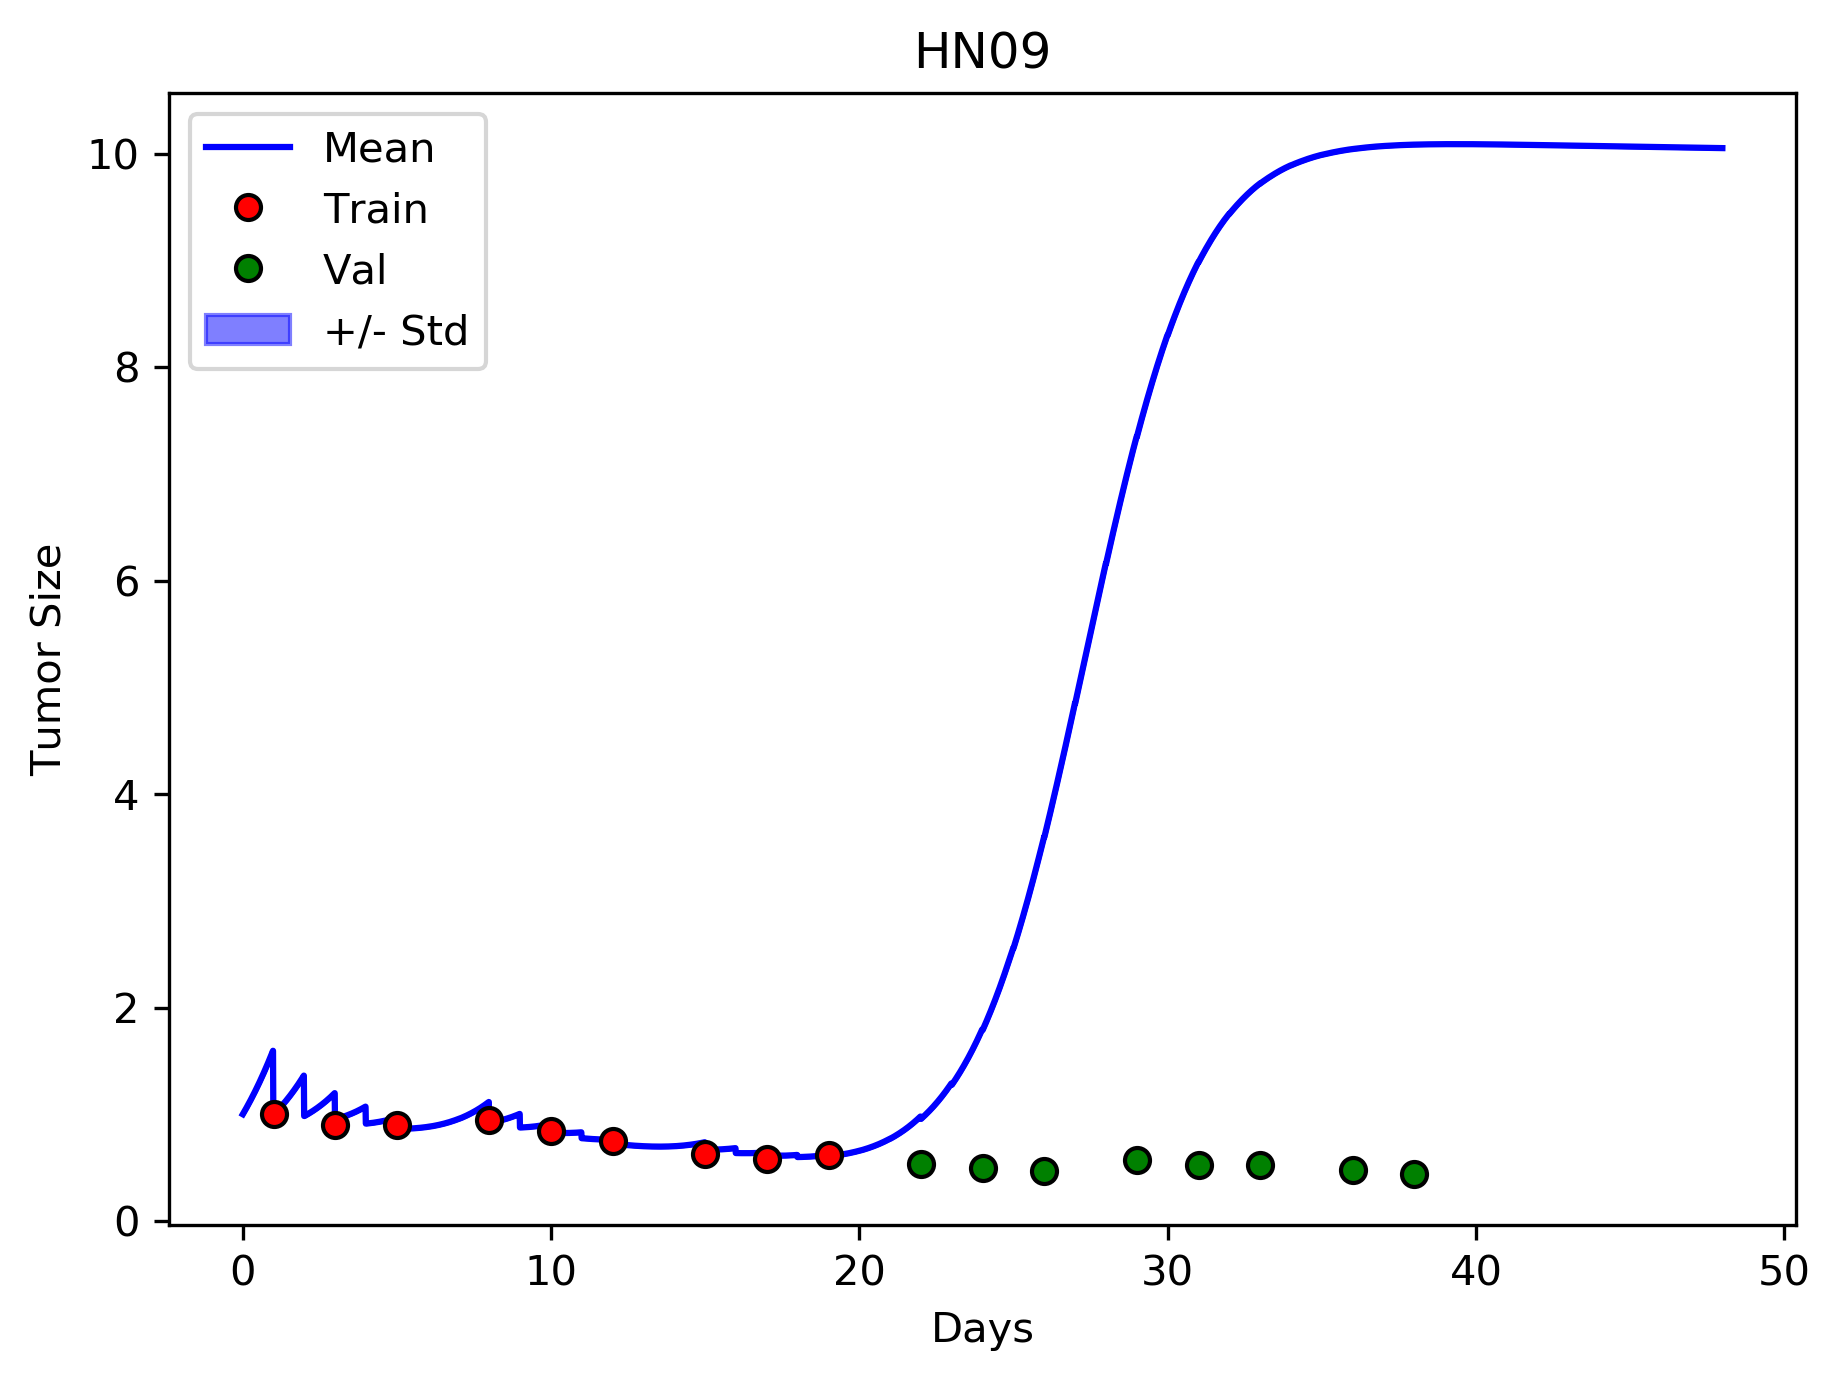

In [158]:
%matplotlib inline

plt.figure(figsize = (7,5),dpi = 300)

# shade the area between the mean of each row of sims, which is the tumor size at each time step for each iteration
#    of the optimization algorithm, plus or minus the standard deviation of each row of sims
plt.fill_between(SimData[:,0], np.mean(sims,axis = 1) - np.std(sims,axis = 1),np.mean(sims,axis = 1) + np.std(sims,axis = 1),color = 'b',alpha = 0.5,label = '+/- Std')

# plot a line for the mean of the tumor sizes at each time step between each iteration of the optimization algorithm
plt.plot(SimData[:,0], np.mean(sims,axis = 1),'b',label = 'Mean')   

# plot the data points for the training set
plt.plot(train[:,0],train[:,1],'ro',mec = 'k',label = 'Train')

# plot the data points for the set we let the algorithm try to match after training, I think
plt.plot(val[:,0],val[:,1],'go',mec = 'k',label = 'Val')

# set appearance properties of the graph
plt.legend()
plt.xlabel('Days')
plt.ylabel('Tumor Size')
plt.title('HN09')
#plt.ylim(0, 12)
plt.legend()
plt.savefig('HN09_Local_In.png')

In [159]:
# save the array containing cost function values in the first column and optimized parameter values in the remaining
#     columns
np.savetxt('Opt_pars-default-settings.txt',opt_pars)

In [165]:
print("%f +- %f" % (1.5, 1.5))

1.500000 +- 1.500000


In [166]:
a = np.array(((1,2,3,4,5),(2,4,6,8,10)))

In [171]:
print(a)
a = np.transpose(a)
print(a)

[[ 1  2  3  4  5]
 [ 2  4  6  8 10]]
[[ 1  2]
 [ 2  4]
 [ 3  6]
 [ 4  8]
 [ 5 10]]


In [173]:
b = np.array_split(a,2)

In [174]:
print(b)

[array([[1, 2],
       [2, 4],
       [3, 6]]), array([[ 4,  8],
       [ 5, 10]])]
